In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer import pv
from pygimli.utils.utils import ProgressBar
import pandas as pd
import pygimli.meshtools as mt
from pygimli.physics.gravimetry import GravityModelling2D

In [2]:
def SolveGravMagHolstein(mesh, pnts, cmp, igrf=None, foot=np.inf):
    """Solve gravity and/or magnetics problem after Holstein (1997).

    Parameters
    ----------
    mesh : pygimli:mesh
        tetrahedral or hexahedral mesh
    pnts : list|array of (x, y, z)
        measuring points
    cmp : list of str
        component list of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
    igrf : list|array of size 3 or 7
        international geomagnetic reference field, either
        [D, I, H, X, Y, Z, F] - declination, inclination, horizontal field,
                               X/Y/Z components, total field OR
        [X, Y, Z] - X/Y/Z components

    Returns
    -------
    out : ndarray (nPoints x nComponents x nCells)
        kernel matrix to be multiplied with density or susceptibility
    """
    if pnts is None:
        pnts = [[0.0, 0.0]]

    doG = np.any([c[0] == "g" for c in cmp])
    doB = np.any([c[0] == "B" and len(c) == 2 for c in cmp]) or "TFA" in cmp
    doBT = np.any([c[0] == "B" and len(c) == 3 for c in cmp])
    B_tens = None

    kernel = np.zeros((mesh.cellCount(), len(pnts), len(cmp)))
    if igrf:
        if len(igrf) == 3:  # an X, Y, Z vector
            F = np.linalg.norm(igrf)
            fakt = F / (4*np.pi)
            B_dir = np.array(igrf) / F
        elif len(igrf) == 7:  # an IGRF vector (D, I, H, X, Y, Z, F)
            fakt = igrf[6] / (4*np.pi)
            myigrf = np.array(igrf[3:6])
            B_dir = myigrf / np.linalg.norm(myigrf)
        else:
            raise Exception("Could not use IGRF vector. Len must be 3 or 7!")
    elif doB or doB:
        raise Exception("Specify IGRF!")

    b_list, c_list = [], []
    for bd in mesh.boundaries():
        b_list.append([n.id() for n in bd.allNodes()])
        c_list.append([bd.leftCell(), bd.rightCell()])

    b_list = np.array(b_list)
    lb = b_list.shape

    n_list = np.array([n.pos() for n in mesh.nodes()])

    cl, cr = [], []
    for i, c in enumerate(c_list):
        if c[0]:
            cl.append([i, c[0].id()])
        if c[1]:
            cr.append([i, c[1].id()])

    cl = np.array(cl)
    cr = np.array(cr)

    rr = range(0, mesh.cellCount())
    rs = np.roll(range(0, lb[1]), -1)

    temp = np.zeros((len(pnts), lb[0], len(cmp)))
    pBar = ProgressBar(its=len(pnts), width=40, sign='+')
    nb = n_list[b_list]
    for i, p in enumerate(pnts):
        r1 = nb - p
        r2 = r1[:, rs, :]
        r0 = r2 - r1
        u = np.sum(np.cross(r1, r2), 1)
        u = u / np.expand_dims(np.linalg.norm(u, axis=1), axis=1)
        ut = np.tile(u, lb[1]).reshape((lb[0], lb[1], 3))
        ll = np.linalg.norm(r0, axis=2)
        t = r0/np.expand_dims(ll, axis=2)
        lm = (np.sum(r1*t, 2) + np.sum(r2*t, 2)) / 2
        h = np.cross(t, ut)
        hn = np.sum(h*r1, 2)
        v = np.sum(ut*r1, 2)
        r1n = np.linalg.norm(r1, axis=2)
        r2n = np.linalg.norm(r2, axis=2)
        rm = (r1n+r2n)/2
        lumbda = ll/(2*rm)

        jj = 0
        if doG: # gravitational field
            g = hn*np.arctanh(lumbda)-np.sign(v)*v*np.arctan2(
                hn*lumbda, (rm*(1-lumbda**2)+abs(v)))
            g_vec = 2 * u * np.expand_dims(np.sum(g, 1), axis=1)

            if 'g' in cmp:
                temp[i, :, jj] = g
                jj += 0

            if 'gx' in cmp:
                temp[i, :, jj] = g_vec[:, 0]
                jj += 1

            if 'gy' in cmp:
                temp[i, :, jj] = g_vec[:, 1]
                jj += 1

            if 'gz' in cmp:
                temp[i, :, jj] = g_vec[:, 2]
                jj += 1

            # if 'gxx' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 0]
            # if 'gxy' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 1]
            # if 'gxz' in cmp:
            #     temp[:, jj]=G_tens[:, 0, 2]
            # if 'gyy' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 1]
            # if 'gyz' in cmp:
            #     temp[:, jj]=G_tens[:, 1, 2]
            # if 'gzz' in cmp:
            #     temp[:, jj]=G_tens[:, 2, 2]

        if doB or doBT:
            # magnetic field vector and gravity gradient tensor
            b = h*np.expand_dims(np.arctanh(lumbda), axis=2) - \
                ut*np.expand_dims(np.sign(v)*np.arctan2(
                    hn*lumbda, (rm*(1-lumbda**2)+abs(v))), axis=2)
            P = np.dot(u, B_dir)
            B_vec = np.expand_dims(P, 1) * np.sum(b, 1)
            B_vec = 2 * np.expand_dims(P, 1) * np.sum(b, 1)

            if 'TFA' in cmp:
                temp[i, :, jj] = fakt*B_vec.dot(B_dir)
                jj += 1

            if 'Bx' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 0]
                jj += 1

            if 'By' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 1]
                jj += 1

            if 'Bz' in cmp:
                temp[i, :, jj] = fakt*B_vec[:, 2]
                jj += 1

            if doBT:  # magnetic gradient tensor
                d = (-2*lumbda*hn) / (r1n*r2n*(1-lumbda**2))
                e = (-2*lumbda*lm) / (r1n*r2n)
                f = (-2*lumbda*v) / (r1n*r2n*(1-lumbda**2))

                h1 = np.expand_dims(h, axis=3)
                h2 = np.swapaxes(h1, 2, 3)
                t1 = np.expand_dims(t, axis=3)
                t2 = np.swapaxes(t1, 2, 3)
                u1 = np.expand_dims(ut, axis=3)
                u2 = np.swapaxes(u1, 2, 3)

                B = (h1*h2-u1*u2)*np.expand_dims(d, (2, 3)) + \
                    (t1*h2+h1*t2)*np.expand_dims(e, (2, 3))/2 + \
                    (h1*u2+u1*h2)*np.expand_dims(f, (2, 3))

                B_tens = np.expand_dims(P, (1, 2)) * np.sum(B, 1)

                if 'Bxx' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 0]
                    jj += 1

                if 'Bxy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 1]
                    jj += 1

                if 'Bxz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 0, 2]
                    jj += 1

                if 'Byy' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 1]
                    jj += 1

                if 'Byz' in cmp:
                    temp[i, :, jj] = fakt*B_tens[:, 1, 2]
                    jj += 1

                if 'Bzz' in cmp:
                    temp[i, :, jj] = fakt * B_tens[:, 2, 2]
                    jj += 1

    pBar.update(i)
    kernel += np.array([np.sum(temp[:, cl[cl[:, 1] == j, 0]], 1) for j in rr])
    kernel -= np.array([np.sum(temp[:, cr[cr[:, 1] == j, 0]], 1) for j in rr])

    return kernel.transpose([1, 2, 0])

In [3]:
# Checkout www.pygimli.org for more examples

In [4]:
class GravityModelling(pg.frameworks.MeshModelling):
    """Magnetics modelling operator using Holstein (2007)."""

    def __init__(self, mesh, points, cmp=["gz"], foot=None):
        """Setup forward operator.

        Parameters
        ----------
        mesh : pygimli:mesh
            tetrahedral or hexahedral mesh
        points : list|array of (x, y, z)
            measuring points
        cmp : list of str
            component of: gx, gy, gz, TFA, Bx, By, Bz, Bxy, Bxz, Byy, Byz, Bzz
        """
        # check if components do not contain g!
        super().__init__(mesh=mesh)
        self.createRefinedForwardMesh(refine=False, pRefine=False)
        self.mesh_ = mesh
        self.sensorPositions = points
        self.components = cmp
        self.footprint = foot
        self.kernel = None
        self.J = pg.matrix.BlockMatrix()
        self.createKernel()

    def createKernel(self):
        """Create computational kernel."""
        self.kernel = SolveGravMagHolstein(self.mesh_,
                                           pnts=self.sensorPositions,
                                           cmp=self.components,
                                           foot=self.footprint)
        self.J = pg.matrix.BlockMatrix()
        self.Ki = []
        self.Ji = []
        for iC in range(self.kernel.shape[1]):
            self.Ki.append(np.squeeze(self.kernel[:, iC, :]))
            self.Ji.append(pg.matrix.NumpyMatrix(self.Ki[-1]))
            self.J.addMatrix(self.Ji[-1], iC*self.kernel.shape[0], 0)

        self.J.recalcMatrixSize()
        self.setJacobian(self.J)


    def setMesh(self, mesh, ignoreRegionManager=False):
        """Set the mesh."""
        super().setMesh(mesh, ignoreRegionManager=False)
        self.createKernel(mesh)


    def response(self, model):
        """Compute forward response."""
        return self.J.dot(model)

    def createJacobian(self, model):
        """Do nothing as this is a linear problem."""


# 2D gravity synthetic modelling and inversion

In the following, we will build the model, create synthetic data, and do
inversion using a depth-weighting function as outlined in the paper.


In [5]:
#pyvista import
import pyvista
pyvista.start_xvfb() 

In [6]:
dataset = pd.read_csv('gravity_processed.csv')

In [7]:
#dataset = pd.read_csv('C:/RWTH_Aachen/thesis/july_bash/gravity_processed.csv')


In [8]:
#gravity data import - processed data from straelen 
#bouger anomaly corrected - background density 2400 g/cc
#making size of array 'compatible' with size of grid (11x11=121)


d_obs_x = dataset['CORRECTEDx']
d_obs_y = dataset['CORRETED']
d_obs_z = dataset['Ele_tiff']
d_obs_grav  = dataset['abs_Grav'] - dataset['gravity_bouger_corrected2400']
d_obs = {'X': d_obs_x, 'Y': d_obs_y, 'Z': d_obs_z, 'abs_grav':
         dataset['abs_Grav'], 'bouger anomaly': dataset['gravity_bouger_corrected2400'],
        'ID':dataset['Point ID'], }
df = pd.DataFrame(d_obs)

In [9]:
df

,X,Y,Z,abs_grav,bouger anomaly,ID
0,218366.5117,381192.5130,41.4175,981184.4800,-2.872241,8001
1,218569.6151,381290.6376,38.6000,981185.3003,-2.713735,8002
2,218743.2993,381370.5864,37.0550,981186.0181,-2.379002,8003
3,218878.7973,381323.1159,35.9175,981186.2231,-2.371430,8004
4,219216.5121,381365.4320,32.1200,981186.9409,-2.473579,8005
...,...,...,...,...,...,...
119,216181.9902,384866.4828,40.0075,981187.2586,-3.324757,4009
120,215712.4380,384844.2620,43.1650,981185.8204,-4.093230,4010
121,215180.8298,384919.1373,45.4475,981184.3324,-5.171050,4011
122,214748.6012,385009.7034,36.3500,981184.5869,-6.884321,4012


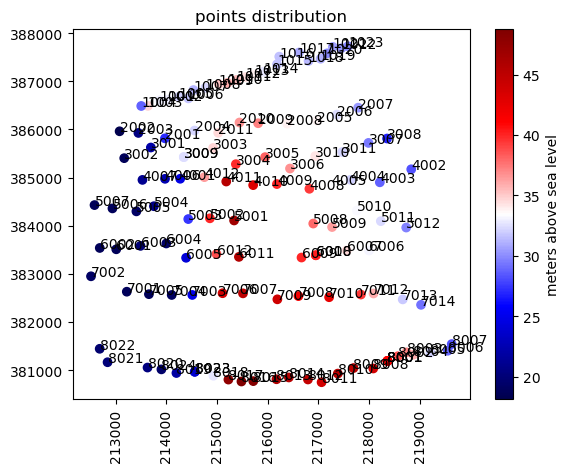

In [10]:
#observed data
for i, txt in enumerate(df['ID']):
    plt.annotate(txt, (df['X'][i], df['Y'][i]))

plt.scatter(df['X'], df['Y'], c=df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()
#Taking the southern line

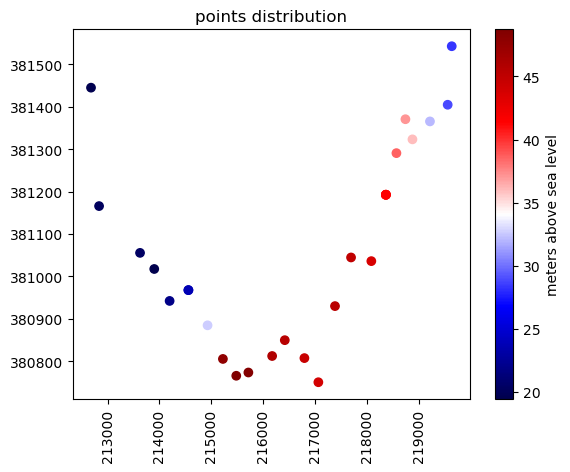

In [11]:
#SOUTH

filtered_df = df[(df['ID'] >= 8000) & (df['ID'] <= 9000)]



plt.scatter(filtered_df['X'], filtered_df['Y'], c=filtered_df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()

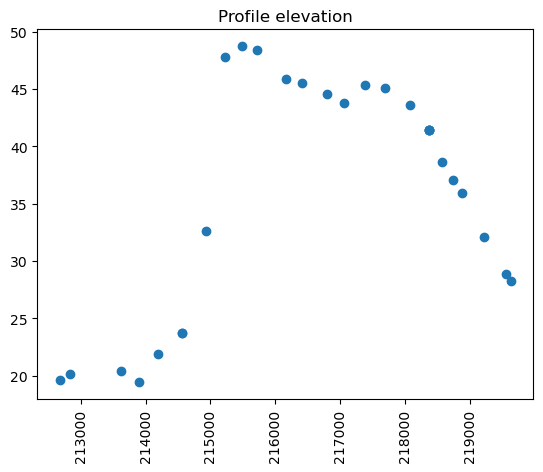

In [12]:
plt.scatter(filtered_df['X'], filtered_df['Z'])
plt.xticks(rotation=90)
plt.title('Profile elevation')
plt.plot()
plt.show()

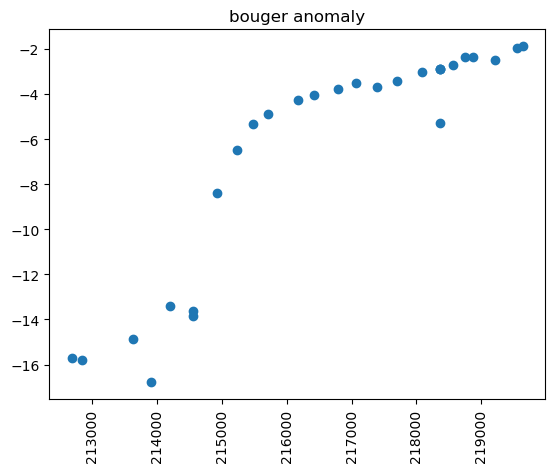

In [13]:
plt.scatter(filtered_df['X'], filtered_df['bouger anomaly'])
plt.xticks(rotation=90)

plt.title('bouger anomaly')
plt.plot()
plt.show()

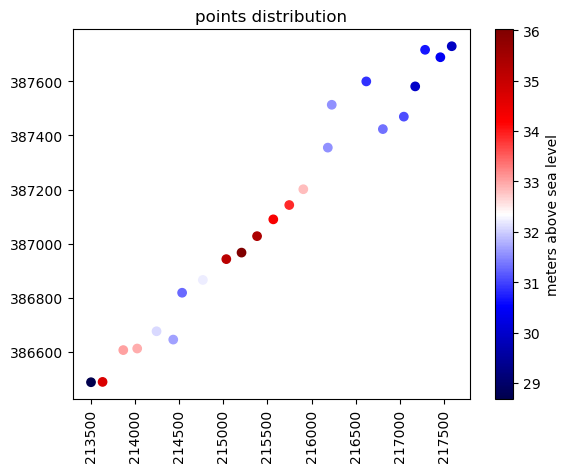

In [14]:
#NOrth

Nfiltered_df = df[(df['ID'] >= 1000) & (df['ID'] <= 2000)]



plt.scatter(Nfiltered_df['X'], Nfiltered_df['Y'], c=Nfiltered_df['Z'], cmap='seismic')
plt.xticks(rotation=90)
plt.colorbar(label="meters above sea level")
plt.title('points distribution')
plt.plot()
plt.show()

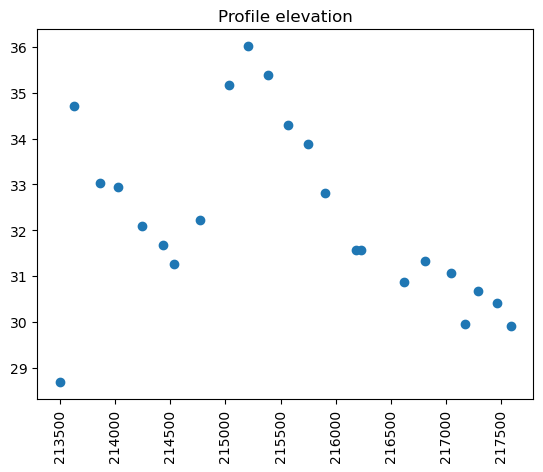

In [15]:
plt.scatter(Nfiltered_df['X'], Nfiltered_df['Z'])
plt.xticks(rotation=90)
plt.title('Profile elevation')
plt.plot()
plt.show()

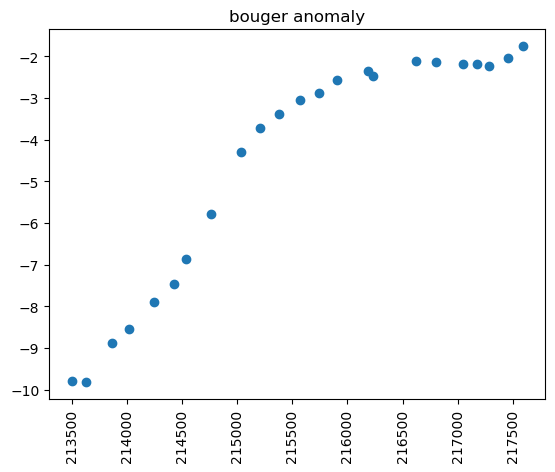

In [16]:
plt.scatter(Nfiltered_df['X'], Nfiltered_df['bouger anomaly'])
plt.xticks(rotation=90)

plt.title('bouger anomaly')
plt.plot()
plt.show()

In [17]:
max(d_obs_x), min(d_obs_x), max(d_obs_z), min(d_obs_z)

(219636.4017, 212508.4086, 48.7325, 18.14)

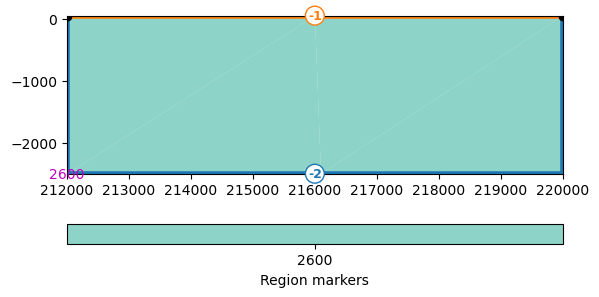

In [18]:
world = mt.createWorld(start=[212000, 50], end=[220000, -2500],
                       marker=2600)
#rect = mt.createRectangle(start=[216000, -1500], end=[220000, -2500],
                        #  marker=2800, area=2000)


geom = world #+ rect
pg.show(geom, markers=True)
mesh = mt.createMesh(geom, quality=33, area=250)

In [19]:
x = np.array(filtered_df['X'])
pnts = np.array([x, np.array(filtered_df['bouger anomaly'])]).T

In [20]:
pnts

array([[ 2.18366512e+05, -2.87224074e+00],
       [ 2.18569615e+05, -2.71373474e+00],
       [ 2.18743299e+05, -2.37900184e+00],
       [ 2.18878797e+05, -2.37143020e+00],
       [ 2.19216512e+05, -2.47357856e+00],
       [ 2.19558156e+05, -1.95034862e+00],
       [ 2.19636402e+05, -1.87937293e+00],
       [ 2.18085862e+05, -3.01312515e+00],
       [ 2.17694752e+05, -3.43953020e+00],
       [ 2.17385165e+05, -3.69826925e+00],
       [ 2.17064326e+05, -3.52283598e+00],
       [ 2.16795342e+05, -3.76678414e+00],
       [ 2.16172993e+05, -4.27433217e+00],
       [ 2.16417033e+05, -4.02697016e+00],
       [ 2.15714817e+05, -4.90401464e+00],
       [ 2.15481129e+05, -5.34679245e+00],
       [ 2.15223573e+05, -6.47190771e+00],
       [ 2.14927636e+05, -8.38330862e+00],
       [ 2.18366512e+05, -2.87224074e+00],
       [ 2.18366512e+05, -2.87224074e+00],
       [ 2.14195948e+05, -1.33973767e+01],
       [ 2.13625458e+05, -1.48765060e+01],
       [ 2.12835534e+05, -1.57918008e+01],
       [ 2.

In [21]:
fop = GravityModelling2D(mesh=mesh, points=pnts)
dRho = pg.solver.parseMapToCellArray([2600, 2600],  mesh)
g = fop.response(dRho)

In [22]:
g

28 [198.18224382034438, 194.1267394971145, 190.0760872848203, 186.40477935083663, 174.9360278658114, 158.53184117504105, 153.70939465019575, 202.75942253890076, 207.52381191318173, 210.29313529724524, 212.48336693445498, 213.74467657528118, 215.15791885263585, 214.84931160940909, 214.92021952534864, 214.37867745316925, 213.3403957127161, 211.57893910901694, 198.18224382034455, 198.18224382034455, 204.6049669644067, 196.00390841962246, 174.81836767517953, 168.49198824204703, 197.77441322717405, 208.09675995511165, 200.1856745249033, 208.0608396139534]

We define an absolute error and add some Gaussian noise.




In [23]:
error = 0.0005
data = g + np.random.randn(len(g)) * error

In [24]:
data

28 [198.18222284366692, 194.12728677600816, 190.07667053139951, 186.40528648595182, 174.93688355198668, 158.53151803535167, 153.70876538186732, 202.75998566650506, 207.52340295716064, 210.29312540876197, 212.4839541723448, 213.744847709212, 215.15812546187576, 214.84879803245434, 214.92043462053692, 214.37862294212098, 213.3395829161462, 211.57903231847365, 198.18264544076106, 198.1815392987848, 204.60527538093908, 196.00361155155778, 174.8182602958257, 168.49247655546787, 197.7751442713948, 208.09705928787983, 200.18580195279074, 208.06163827665958]

The model response is then plotted along with the model




(212000.0, 220000.0)

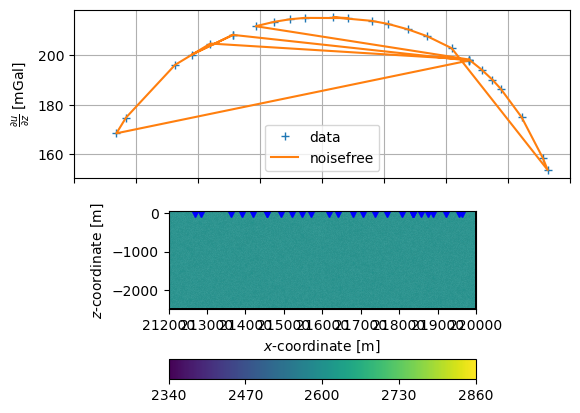

In [25]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+", label="data")
ax[0].plot(x, g, "-", label="noisefree")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, dRho, ax=ax[1])
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

For inversion, we create a new mesh from the rectangular domain and setup a
new instance of the modelling operator.




In [26]:
mesh = mt.createMesh(world, quality=33, area=250)
fop = GravityModelling2D(mesh=mesh, points=pnts)

## Depth weighting

In the paper of Li & Oldenburg (1996), they propose a depth weighting of the
constraints with the formula

\begin{align}w_z = \frac{1}{(z+z_0)^{3/2}}\end{align}




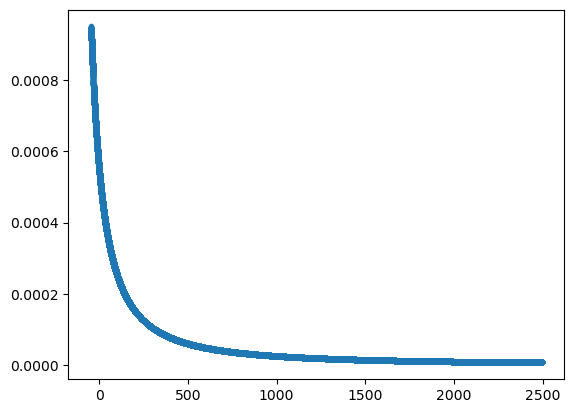

In [27]:
cz = -pg.y(mesh.cellCenters())
z0 = 150
wz = 1 / (cz+z0)**1.5
pg.plt.plot(cz, wz, ".")

## Inversion

For inversion, we use geostatistic regularization with a higher correlation
length for x, compared to y, to account for the large equivalence.
We limit the model to reasonable density contrasts of +/- 1000 kg/m^3.
As the depth weighting decreases the local regularization weights, we have
to increase the overall regularization strength lambda.




In [28]:
fop.region(2600).setConstraintType(2)
inv = pg.Inversion(fop=fop)
inv.setRegularization(limits=[2200, 3000]) #trans="Cot",correlationLengths=[100, 50])
inv.setConstraintWeights(-wz) #we are in subsurface as it is set up in the geometry
rho = inv.run(g, absoluteError=error, lam=3e5, verbose=True)

30/07/23 - 00:59:02 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 00:59:02 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 00:59:02 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x152538e6c130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x152549f1bfa0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x15254dda1040>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 139264 x 139264
calculating jacobian matrix (forced=1)...... 0.000804655 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.76114e+12 + 0 * 300000 = 3.76114e+12
-----

## Visualization

For showing the model, we again plot model response and model.




30/07/23 - 01:00:56 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

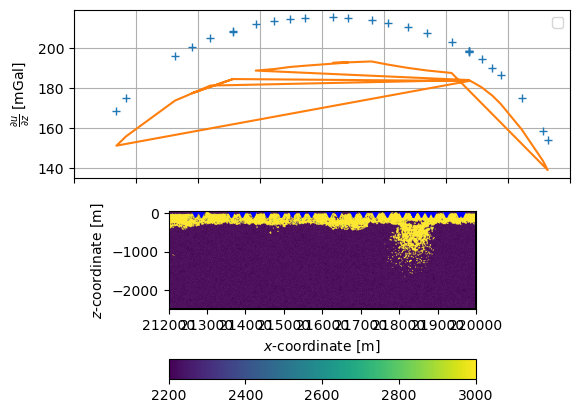

In [29]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1],  fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [28]:
fop.region(2600).setConstraintType(2)
inv = pg.Inversion(fop=fop)
#inv.setRegularization(limits=[-3000, 3000], trans="Cot",
 #                    correlationLengths=[1000, 50])
inv.setConstraintWeights(-wz)
rho = inv.run(g, absoluteError=error, lam=1, verbose=True)

30/07/23 - 11:02:56 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 11:02:56 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 11:02:56 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x146ff7b6a040>
Data transformation: <pgcore._pygimli_.RTrans object at 0x146ff7af7dc0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x146ff7bb5400>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 139264 x 139264
calculating jacobian matrix (forced=1)...... 0.00010384 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.76114e+12 + 0 * 1 = 3.76114e+12
-----------------------------------------------------------------

30/07/23 - 11:03:55 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

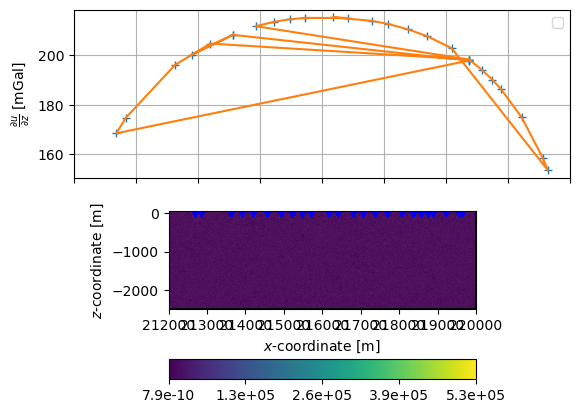

In [29]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [32]:
fop.region(2600).setConstraintType(2800)
inv = pg.Inversion(fop=fop)
#inv.setRegularization(limits=[-10000, 10000], trans="Cot",
#                      correlationLengths=[12, 2])
#inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=2e6, verbose=True)

30/07/23 - 01:02:06 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 01:02:06 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 01:02:06 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x152538e6c130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x152549fecb80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x152548edaa60>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 208329 x 139264
calculating jacobian matrix (forced=1)...... 0.000100158 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.76114e+12 + 0 * 2e+06 = 3.76114e+12
------

30/07/23 - 01:03:05 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

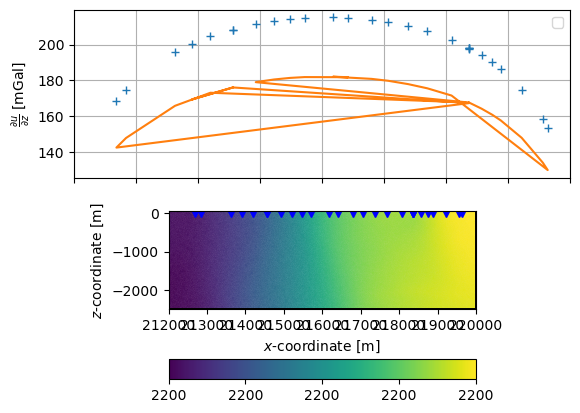

In [33]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [34]:
fop.region(2600).setConstraintType(3000)
inv = pg.Inversion(fop=fop)
#inv.setRegularization(limits=[-10000, 10000], trans="Cot",
#                      correlationLengths=[12, 2])
#inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=5e6, verbose=True)

30/07/23 - 01:03:09 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 01:03:09 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 01:03:09 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x152538e6c130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x15252e4889a0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x1525490c30a0>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 208329 x 139264
calculating jacobian matrix (forced=1)...... 0.00262274 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.76114e+12 + 0 * 5e+06 = 3.76114e+12
-------

30/07/23 - 01:04:10 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

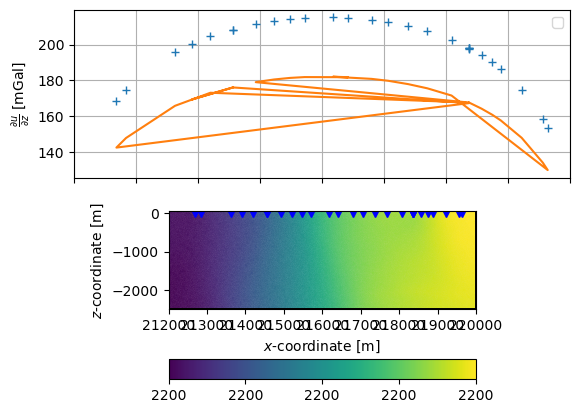

In [35]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [36]:
fop.region(2600).setConstraintType(2800)
inv = pg.Inversion(fop=fop)
#inv.modelTrans = pg.trans.TransCotLU(200, 202)
#inv.setRegularization(limits=[-10000, 10000], trans="Cot",
#                      correlationLengths=[12, 2])
#inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=1e4, verbose=True)

30/07/23 - 01:04:13 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 01:04:13 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 01:04:13 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x152538e6c130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x1525490bdbe0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x152538e1c820>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 208329 x 139264
calculating jacobian matrix (forced=1)...... 8.7398e-05 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
------------------------------------------------------

30/07/23 - 01:08:52 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

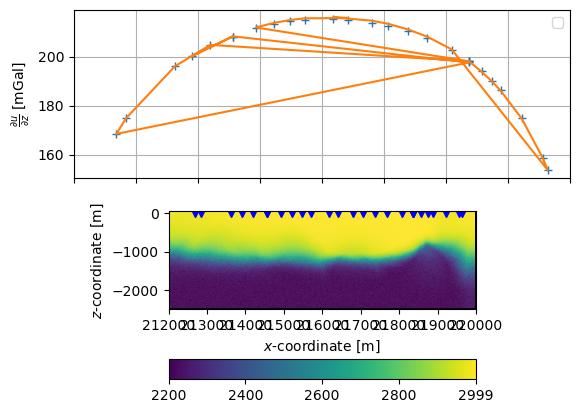

In [37]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [30]:
fop.region(2600).setConstraintType(2800)
inv = pg.Inversion(fop=fop)
#inv.modelTrans = pg.trans.TransCotLU(200, 202)
#inv.setRegularization(limits=[-10000, 10000], trans="Cot",
#                      correlationLengths=[12, 2])
#inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=5e4, verbose=True)

30/07/23 - 11:03:58 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 11:03:58 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 11:03:58 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x146ff7b6a040>
Data transformation: <pgcore._pygimli_.RTrans object at 0x146ff299cfa0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x146ff7bb5400>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
min/max(dweight) = 2000/2000
Building constraints matrix
constraint matrix of size(nBounds x nModel) 208329 x 139264
calculating jacobian matrix (forced=1)...... 0.000205682 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.76114e+12 + 0 * 50000 = 3.76114e+12
------------------------------------------------------------

30/07/23 - 11:05:22 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

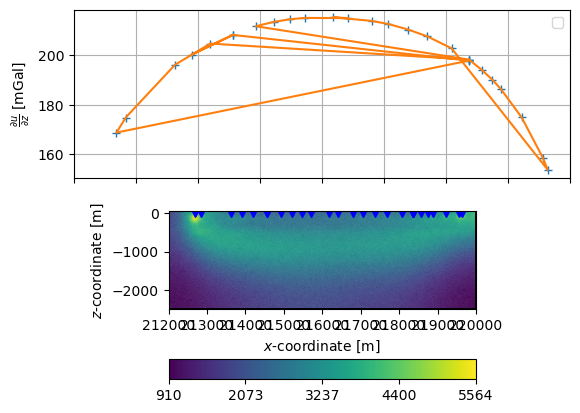

In [31]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

In [34]:

fop.region(2600).setConstraintType(2800)
inv = pg.Inversion(fop=fop)
#inv.modelTrans = pg.trans.TransCotLU(200, 202)
#inv.setRegularization(limits=[-10000, 10000], trans="Cot",
#                      correlationLengths=[12, 2])
#inv.setConstraintWeights(wz)
rho = inv.run(g, absoluteError=error, lam=1e4, verbose=True)

30/07/23 - 11:34:00 - pyGIMLi - INFO - Use median(data values)=201.47254853190202
30/07/23 - 11:34:00 - pyGIMLi - INFO - Created startmodel from forward operator: 139264 [201.47254853190202,...,201.47254853190202]
30/07/23 - 11:34:00 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2000/2000
fop: <pygimli.physics.gravimetry.gravMagModelling.GravityModelling2D object at 0x146ff7b6a040>
Data transformation: <pgcore._pygimli_.RTrans object at 0x146ff79b1220>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x146ff7bb5400>
min/max (data): 154/215
min/max (error): 2.3e-04%/3.3e-04%
min/max (start model): 201/201
--------------------------------------------------------------------------------
min/max(dweight) = 2000/2000
Building constraints matrix
--------------------------------------------------------------------------------
inv.iter 1 ... constraint matrix of size(nBounds x nModel) 208329 x 139264
calculating jacobian matrix (forced=1)...... 0.000286853 s
min data = 153.709 max data = 215.158 (28)
min error = 2.32387e-06 max error = 3.25289e-06 (28)
min response = 11.9109 max response = 16.6725 (28)
calc without reference model
0: rms/rrms(data, response) = 183.253/92.2511%
0: chi^2(data, response, error, log) = 1.34326e+11
0: Phi = 3.

30/07/23 - 11:39:46 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(212000.0, 220000.0)

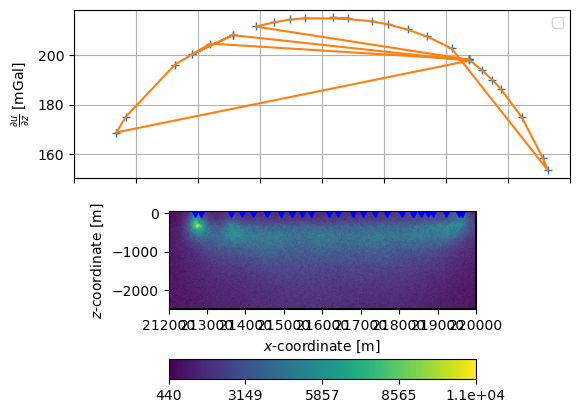

In [35]:
fig, ax = pg.plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(x, data, "+")
ax[0].plot(x, inv.response, "-")
ax[0].set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax[0].grid()
ax[0].legend()

pg.show(mesh, rho, ax=ax[1], logScale=False)
#pg.viewer.mpl.drawPLC(ax[1], rect, fillRegion=False)
ax[1].plot(x, x*0, 'bv')
ax[1].set_xlabel('$x$-coordinate [m]')
ax[1].set_ylabel('$z$-coordinate [m]')
ax[1].set_ylim((-2500, 50))
ax[1].set_xlim((212000, 220000))

## References

-  Li, Y. & Oldenburg, D. (1996): 3-D inversion of magnetic data.
   Geophysics 61(2), 394-408.
-  Holstein, H., Sherratt, E.M., Reid, A.B.  (2007): Gravimagnetic field
   tensor gradiometry formulas for uniform polyhedra, SEG Ext. Abstr.




In [ ]:
inv.inv

In [48]:
#ertmanager.inv.phiModel() #x
# ertmanager.inv.phiData() #y 
#do it with the inverse of lambda? 
print('RUNNING L CURVE CRITERION ')
lambdas = np.logspace(-1,3,8)
        
phimodels = []
phidatas = []
chis = []
mods = {}


pg.tic()
for i, a in enumerate(lambdas):
        print(f'Now using LAMBDA {a} - {i} ITERATION ')
        #ertmanager = ERTManager(verbose=True)
        #inv.checkData(data)
        mod = data.invert(data, mesh=mesh, lam=a, secNodes=3, verbose=True, maxIter=25)
        phimodels.append(rho.inv.phiModel())
        phidatas.append(rho.inv.phiData())
        chis.append(rho.inv.chi2())
        mods[a] = mod
pg.toc()

#first derivatives 
dx= np.gradient(phimodels)
dy = np.gradient(phidatas)

#second derivatives 
d2x = np.gradient(dx)
d2y = np.gradient(dy)

#calculation of curvature from the typical formula
curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
print("The optimal alpha = ", lambdas[np.argmax(curvature)+1])

plt.scatter(phimodels, phidatas, c='g')
plt.xlabel('Phi Model')
plt.ylabel('Phi Data')
plt.title('L-curve analysis')
for i, txt in enumerate(lambdas):
         txt = np.round(txt, 3)
         txt = str(txt)
         plt.annotate(txt, (phimodels[i], phidatas[i]))
plt.plot(phimodels[np.argmax(curvature)+1], phidatas[np.argmax(curvature)+1], '+b')
plt.savefig(PATHPLOTS + 'Lcurveplot.jpg')
plt.show()

RUNNING L CURVE CRITERION 
Now using LAMBDA 0.1 - 0 ITERATION 


AttributeError: 'RVector' object has no attribute 'invert'

In [ ]:
fop.